In [18]:
import pyarrow
import fastparquet
import pandas as pd
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np


## Exploratory Analysis - Data Preview and Cleaning

In [19]:
#Data Download and Preview 
df = pd.read_parquet('/Users/camryncurtis/Documents/GitHub/Capstone-Project/data/02_filtered/summer_lax_snappy.parquet')
print(df.head())


                              legId  searchDate  flightDate startingAirport  \
0  006987aea766442f625ccd84bde23ff3  2022-04-17  2022-06-01             LAX   
1  2181b0ab7161f081228a0c600d756eaf  2022-04-17  2022-06-01             LAX   
2  1ad5b31e3269695b008e5001f06d627a  2022-04-17  2022-06-01             LAX   
3  8e3f3570d010c80500d98f66bfc49777  2022-04-17  2022-06-01             LAX   
4  7ff208a7f5d75b1a97d54b983eb4fabf  2022-04-17  2022-06-01             LAX   

  destinationAirport fareBasisCode travelDuration  isBasicEconomy  \
0                ATL         GA7NR       PT14H25M           False   
1                ATL         GA7NR       PT10H42M           False   
2                ATL         UA7NR        PT9H49M           False   
3                ATL        U0XSNR       PT12H42M           False   
4                ATL       M03PXP5        PT6H17M           False   

   isRefundable  isNonStop  ...  seatsRemaining  totalTravelDistance  \
0         False      False  ...       

In [20]:
#Datatype Summary 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4329731 entries, 0 to 4329730
Data columns (total 22 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   legId                              object 
 1   searchDate                         object 
 2   flightDate                         object 
 3   startingAirport                    object 
 4   destinationAirport                 object 
 5   fareBasisCode                      object 
 6   travelDuration                     object 
 7   isBasicEconomy                     bool   
 8   isRefundable                       bool   
 9   isNonStop                          bool   
 10  baseFare                           float64
 11  totalFare                          float64
 12  seatsRemaining                     int64  
 13  totalTravelDistance                float64
 14  segmentsDepartureTimeEpochSeconds  object 
 15  segmentsArrivalTimeEpochSeconds    object 
 16  segmentsArrivalAir

### Checking and Dropping Null Values 

In [21]:
#Look for null values
print(df.isnull().sum())
#Drop null values 
df = df.dropna()

legId                                     0
searchDate                                0
flightDate                                0
startingAirport                           0
destinationAirport                        0
fareBasisCode                             0
travelDuration                            0
isBasicEconomy                            0
isRefundable                              0
isNonStop                                 0
baseFare                                  0
totalFare                                 0
seatsRemaining                            0
totalTravelDistance                  456372
segmentsDepartureTimeEpochSeconds         0
segmentsArrivalTimeEpochSeconds           0
segmentsArrivalAirportCode                0
segmentsDepartureAirportCode              0
segmentsAirlineName                       0
segmentsDurationInSeconds                 0
segmentsDistance                          0
segmentsCabinCode                         0
dtype: int64


### Datatype Conversions 



In [22]:
#Handle Data Types

# Convert boolean columns to 0 and 1
boolean_columns = ['isBasicEconomy', 'isRefundable', 'isNonStop'] 
df[boolean_columns] = df[boolean_columns].astype(int)

#Change dates to datetime
df['searchDate'] = pd.to_datetime(df['searchDate'])
df['flightDate'] = pd.to_datetime(df['flightDate'])

# Convert travelDuration from ISO 8601 to minutes
def convert_duration(duration):
    if not isinstance(duration, str): 
        return None
    
    # Regex pattern for ISO 8601 duration
    match = re.match(r'P(?:(\d+)D)?T(?:(\d+)H)?(?:(\d+)M)?', duration)
    if match:
        days = int(match.group(1)) if match.group(1) else 0
        hours = int(match.group(2)) if match.group(2) else 0
        minutes = int(match.group(3)) if match.group(3) else 0
        return (days * 24 * 60) + (hours * 60) + minutes  # Convert everything to minutes
    
    return None 

# Apply conversion and store in a new column or overwrite the existing one
df['travelDurationMinutes'] = df['travelDuration'].apply(convert_duration)

# Check for any rows where conversion failed (should be empty if all are valid)
conversion_issues = df[df['travelDurationMinutes'].isnull()]
print(f"Rows with conversion issues: {len(conversion_issues)}")

#Drop the original travelDuration column
df.drop(columns=['travelDuration'], inplace=True)



Rows with conversion issues: 0


### Duplicate Handling


In [23]:
#Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

#Drop null values
df = df.dropna().reset_index(drop=True)

Number of duplicate rows: 0


# Initial Visualizations and Exploratory Data Analysis 

## Numerical Distribution Visualizations and Statistics (Univariate)


### Summary Statistics for Numerical Features


In [24]:
#The starting datatypes are not entirely representative of numerical/categorical features
#Numerical features are listed below for accurate summary statistics and analysis
numerical_features = ['baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance', 'travelDurationMinutes']

summary_stats = df[numerical_features].describe().round(2)

print(summary_stats)

         baseFare   totalFare  seatsRemaining  totalTravelDistance  \
count  3873359.00  3873359.00      3873359.00           3873359.00   
mean       388.83      440.29            6.09              2195.85   
std        175.77      189.73            2.59               670.82   
min         26.98       43.60            0.00               338.00   
25%        283.72      327.60            4.00              1943.00   
50%        378.61      428.60            7.00              2438.00   
75%        478.14      537.60            9.00              2607.00   
max       6432.56     6934.10           10.00              3866.00   

       travelDurationMinutes  
count             3873359.00  
mean                  462.39  
std                   179.93  
min                    72.00  
25%                   339.00  
50%                   464.00  
75%                   567.00  
max                  1368.00  


### Histogram Visualization for Numerical Features to Understand Distribution

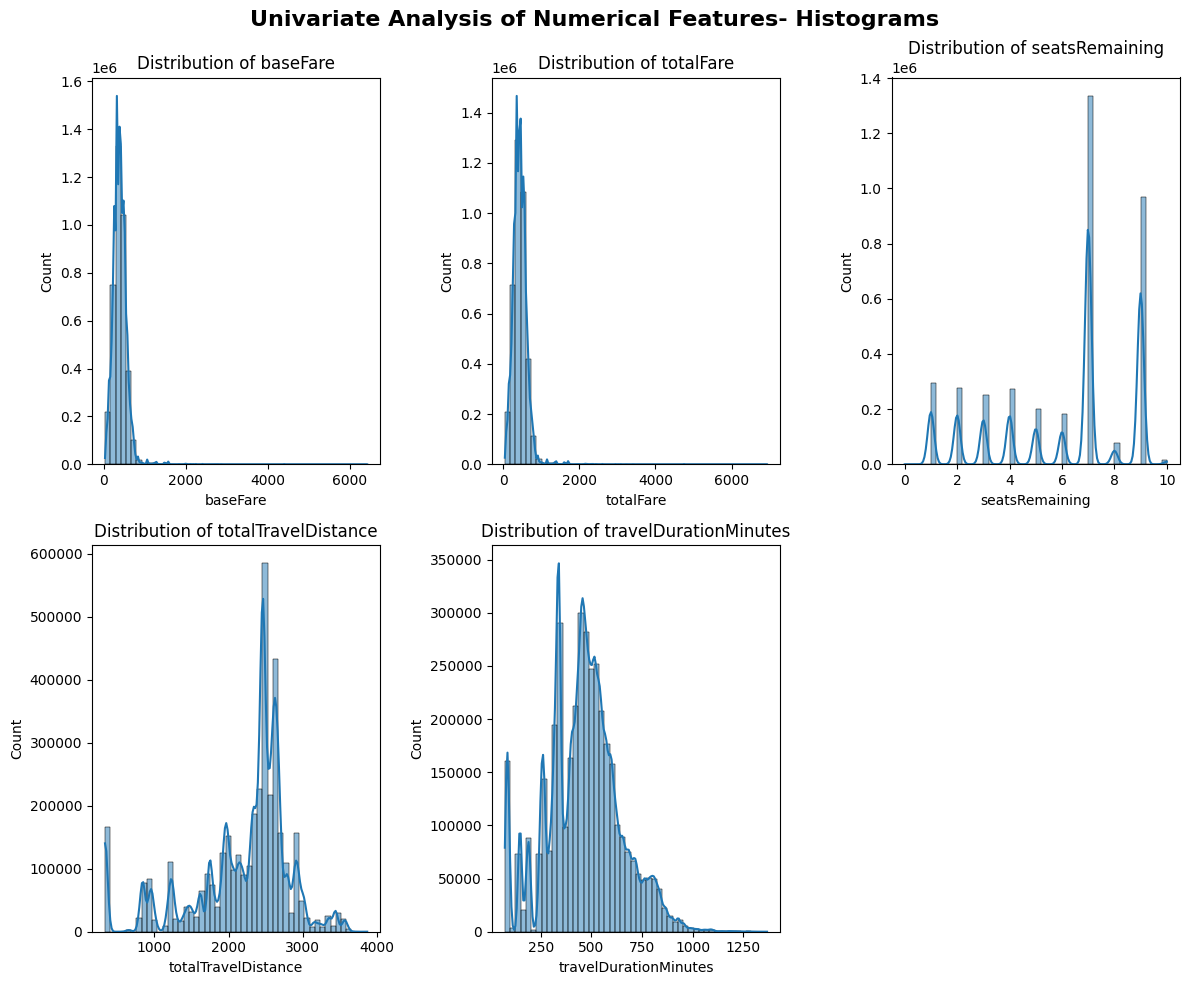

In [25]:
# Univariate Analysis - Histograms
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

for ax, feature in zip(axes.flat, numerical_features):
    sns.histplot(df[feature].dropna(), bins=50, kde=True, ax=ax)
    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")
    
if len(numerical_features) < len(axes):
    for j in range(len(numerical_features), len(axes)):
        fig.delaxes(axes[j])
    
fig.suptitle("Univariate Analysis of Numerical Features- Histograms", fontsize=16, fontweight='bold')

plt.tight_layout() 
plt.show()

Fare has a strong right-skew. Skewing and variety of numerical values may require correction and normalization later. 

### Boxplots for Numerical Features to Visualize Distribution and Outliers 

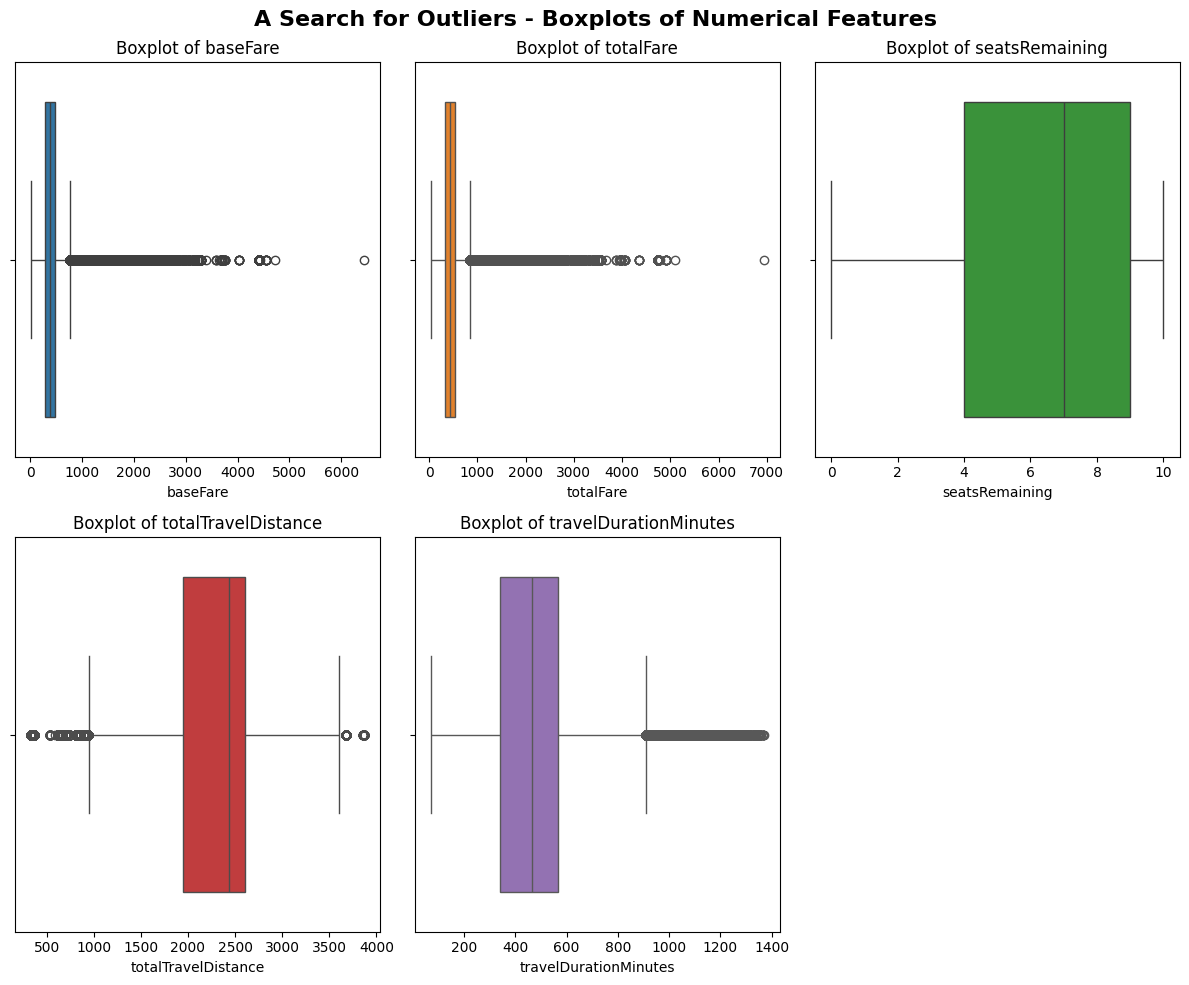

In [26]:
# Boxplots to check for outliers

# Define unique colors for each feature
unique_colors = sns.color_palette("tab10", len(numerical_features)) 

fig, axes = plt.subplots(2, 3, figsize=(12, 10))  
axes = axes.flatten()  

for ax, feature, color in zip(axes, numerical_features, unique_colors):
    sns.boxplot(x=df[feature], ax=ax, color=color)
    ax.set_title(f"Boxplot of {feature}")
    
if len(numerical_features) < len(axes):
    for j in range(len(numerical_features), len(axes)):
        fig.delaxes(axes[j])

fig.suptitle("A Search for Outliers - Boxplots of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()



The boxplots show an abundance of outliers, but this may be representative of the nature of airfare instead of errors or other issues with the data

### Pairplot of Numerical Features for Alternative Distribution Analysis

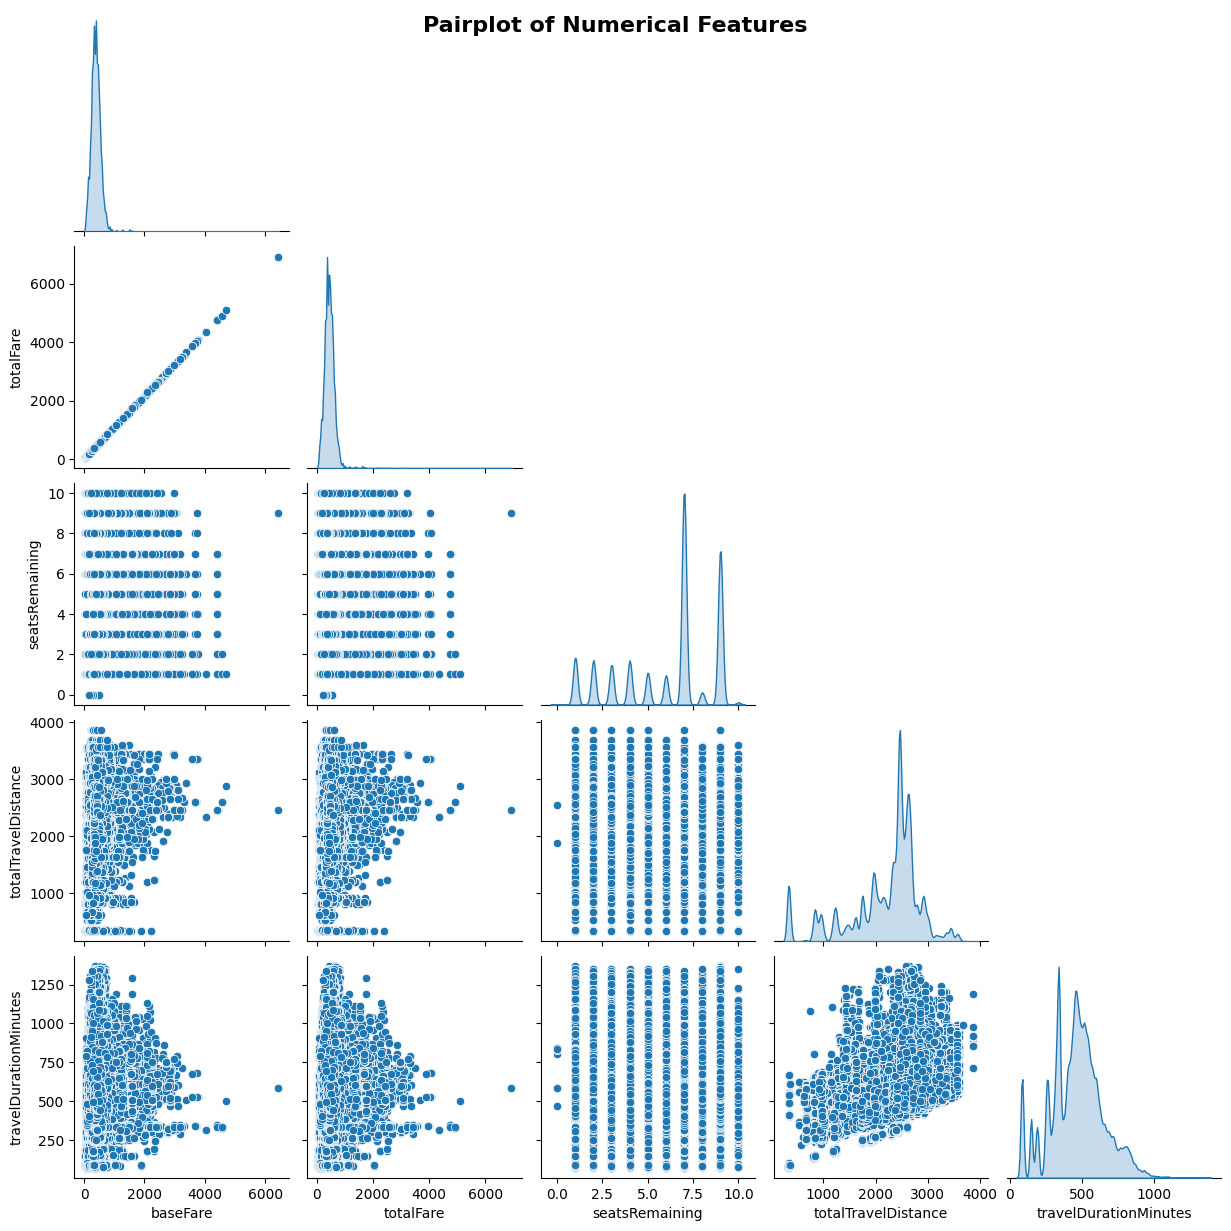

In [27]:
# Pairplot for relationships
pairplot = sns.pairplot(df[['baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance', 'travelDurationMinutes']], diag_kind='kde', corner=True)
pairplot.fig.suptitle("Pairplot of Numerical Features", fontsize=16, fontweight='bold')
plt.show()

## Numerical Comparison Visualizations (Multivariate)

### Lineplot Visualization of Average Airfare Price over the Summer Season

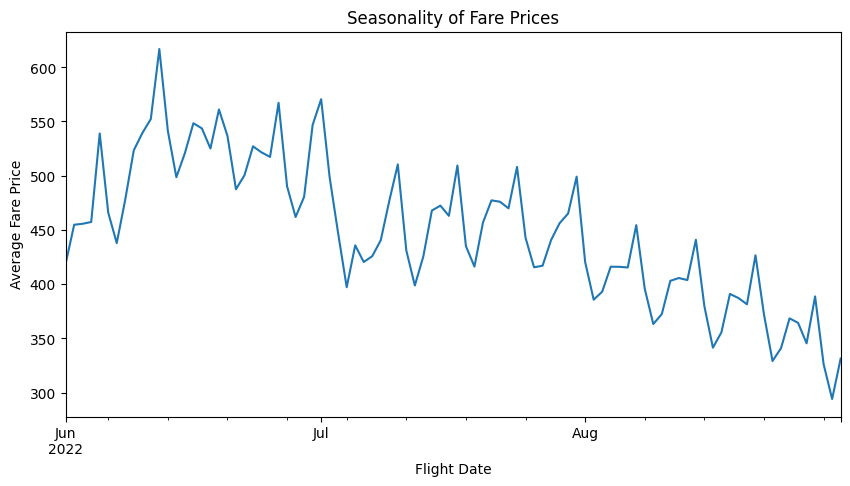

In [28]:
# Seasonality Analysis - Average Fare Over Time
fare_by_date = df.groupby('flightDate')['totalFare'].mean()
plt.figure(figsize=(10, 5))
fare_by_date.plot()
plt.xlabel("Flight Date")
plt.ylabel("Average Fare Price")
plt.title("Seasonality of Fare Prices")
plt.show()

Airfare is most expensive at the beginning of the summer season, experiencing a peak and study downfall before 4th of July and after respectively. Average airfare steadily falls through august. 

### Comparison of Travel Distance and Duration to Total Fare

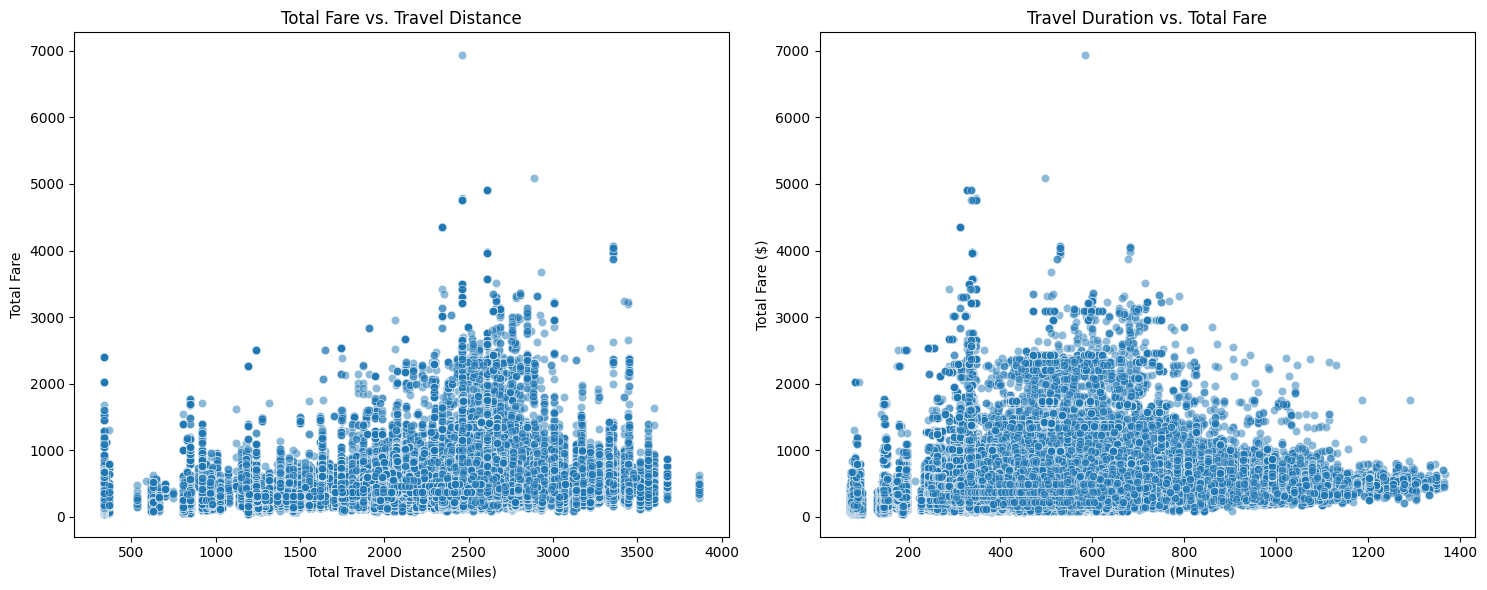

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot 1: Travel Distance vs. Total Fare
sns.scatterplot(x=df['totalTravelDistance'], y=df['totalFare'], alpha=0.5, ax=axes[0])
axes[0].set_title("Total Fare vs. Travel Distance")
axes[0].set_xlabel("Total Travel Distance(Miles)")
axes[0].set_ylabel("Total Fare")

# Plot 2: Travel Duration vs. Total Fare
sns.scatterplot(x=df['travelDurationMinutes'], y=df['totalFare'], alpha=0.5, ax=axes[1])
axes[1].set_title("Travel Duration vs. Total Fare")
axes[1].set_xlabel("Travel Duration (Minutes)")
axes[1].set_ylabel("Total Fare ($)")

plt.tight_layout()
plt.show()

Total Fare is relatively evenly spread with travel distance, with a sight peak around the 2500-3000 mile mark. Travel Duration and Total Fare are slightly right skewed. 

### Violin Plot Visualizing Price Distribution According to Seats Remaining

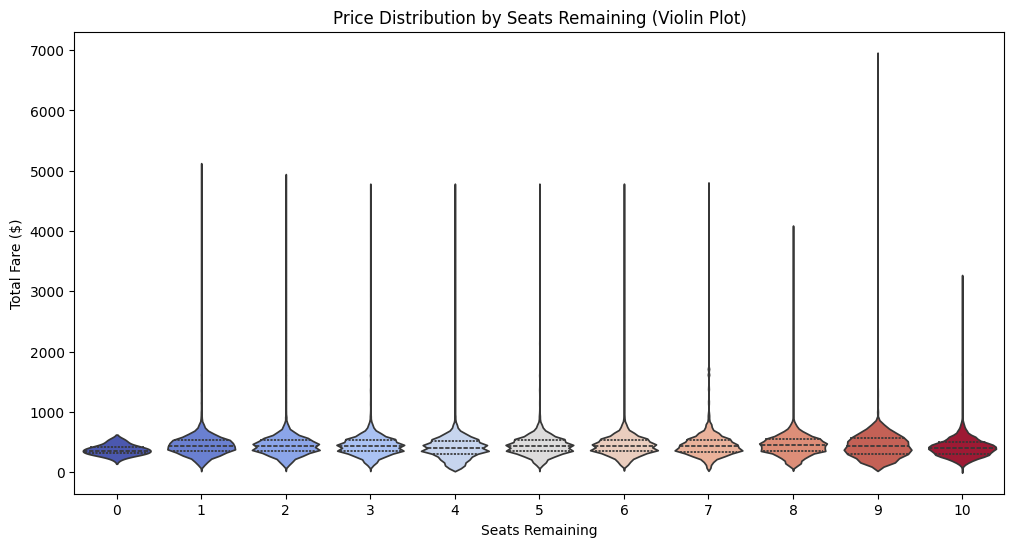

In [30]:
plt.figure(figsize=(12,6))
sns.violinplot(x=df['seatsRemaining'], y=df['totalFare'], inner="quartile", density_norm='width', palette="coolwarm", hue=df['seatsRemaining'], legend=False)
plt.title("Price Distribution by Seats Remaining (Violin Plot)")
plt.xlabel("Seats Remaining")
plt.ylabel("Total Fare ($)")
plt.show()


The price distribution by seats remaining shows little variation in changes in the fare based on how many seats are left on the plane

### Numerical Correlations

In [31]:
# Compute correlation only for selected columns
correlation_matrix = df[numerical_features].corr()
print(correlation_matrix)


                       baseFare  totalFare  seatsRemaining  \
baseFare               1.000000   0.999654       -0.001359   
totalFare              0.999654   1.000000       -0.004695   
seatsRemaining        -0.001359  -0.004695        1.000000   
totalTravelDistance    0.407297   0.415230       -0.019324   
travelDurationMinutes  0.250030   0.271814       -0.117103   

                       totalTravelDistance  travelDurationMinutes  
baseFare                          0.407297               0.250030  
totalFare                         0.415230               0.271814  
seatsRemaining                   -0.019324              -0.117103  
totalTravelDistance               1.000000               0.629898  
travelDurationMinutes             0.629898               1.000000  


## Categorical Visualizations and Statistics (Univariate)

### Categorical Feature Classification and Breakdown

In [32]:
#Identifying categorical features
categorical_features = ['isBasicEconomy', 'isNonStop', 'isRefundable', 'destinationAirport','fareBasisCode']

### Checking datatypes

In [33]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3873359 entries, 0 to 3873358
Data columns (total 22 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   legId                              object        
 1   searchDate                         datetime64[ns]
 2   flightDate                         datetime64[ns]
 3   startingAirport                    object        
 4   destinationAirport                 object        
 5   fareBasisCode                      object        
 6   isBasicEconomy                     int64         
 7   isRefundable                       int64         
 8   isNonStop                          int64         
 9   baseFare                           float64       
 10  totalFare                          float64       
 11  seatsRemaining                     int64         
 12  totalTravelDistance                float64       
 13  segmentsDepartureTimeEpochSeconds  object        
 14  se

### Finding the unique values in each category

In [34]:
#Check for number of unique categories
for feature in categorical_features:
    print(f"{feature}: {df[feature].nunique()} unique values")

isBasicEconomy: 2 unique values
isNonStop: 2 unique values
isRefundable: 2 unique values
destinationAirport: 15 unique values
fareBasisCode: 4658 unique values


### Visualizing the Distribution of Values for Categorical Variables 

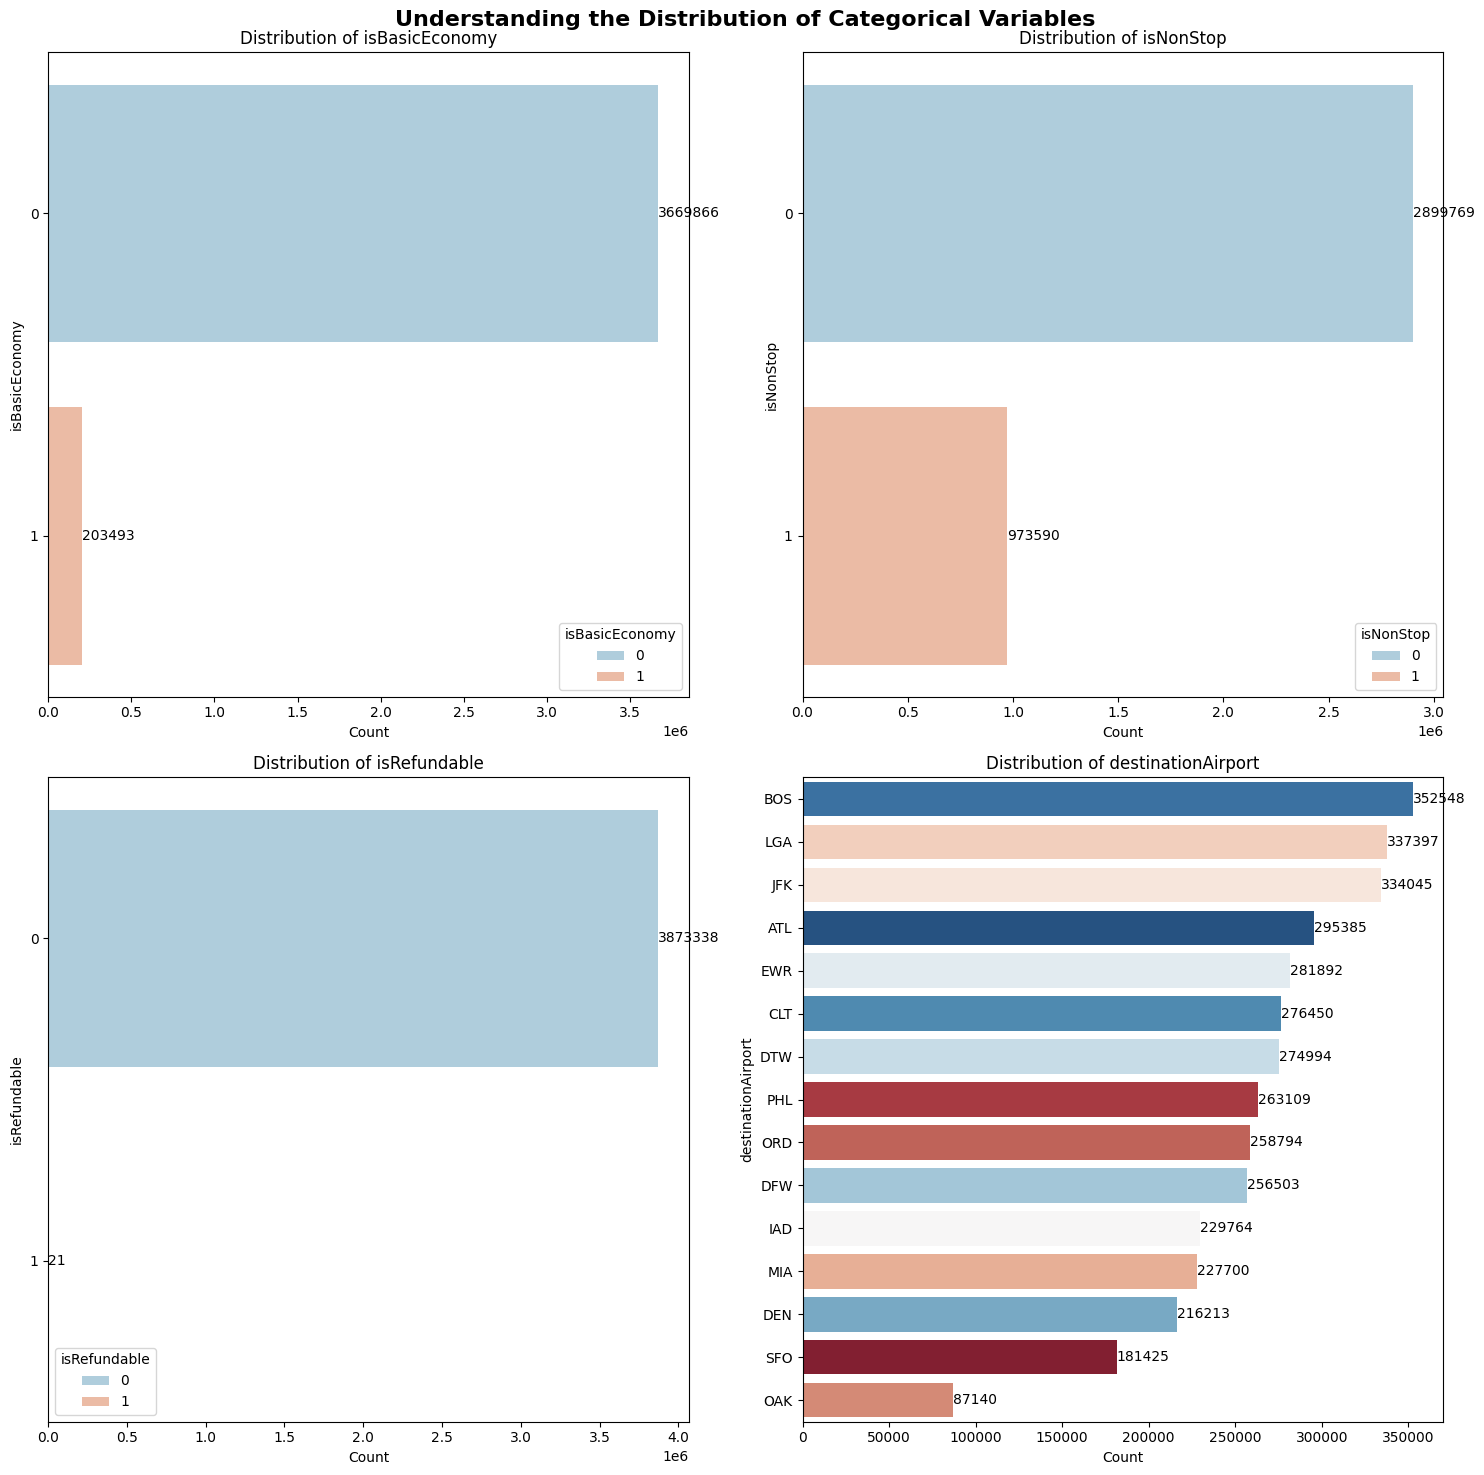


Value counts for isBasicEconomy:
isBasicEconomy
0    3669866
1     203493
Name: count, dtype: int64

Value counts for isNonStop:
isNonStop
0    2899769
1     973590
Name: count, dtype: int64

Value counts for isRefundable:
isRefundable
0    3873338
1         21
Name: count, dtype: int64

Value counts for destinationAirport:
destinationAirport
BOS    352548
LGA    337397
JFK    334045
ATL    295385
EWR    281892
CLT    276450
DTW    274994
PHL    263109
ORD    258794
DFW    256503
IAD    229764
MIA    227700
DEN    216213
SFO    181425
OAK     87140
Name: count, dtype: int64


In [35]:
#Removal of fareBasisCode as the fare basis codes are not consistent across varying airlines, and does not provide useful information in this context
categorical_features_refined = ['isBasicEconomy', 'isNonStop', 'isRefundable', 'destinationAirport']

fig, axes = plt.subplots(2, 2, figsize=(15, 15)) 
axes = axes.flatten()

for i, col in enumerate(categorical_features_refined):
    ax = sns.countplot(y=df[col], ax=axes[i], order=df[col].value_counts().index, hue=df[col], palette="RdBu_r")

    # Add count labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%d') 

    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("Count")
    
fig.suptitle("Understanding the Distribution of Categorical Variables", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


# Print counts of occurrences for categorical variables
for feature in categorical_features_refined:
    print(f"\nValue counts for {feature}:")
    print(df[feature].value_counts())


isRefundable has almost no refundable values, suggesting this category should be dropped. There is a widespread of destination airports, suggesting possible variations and insights that might be gained from this categorical variable. isBasicEconomy and isNonStop are both dominated by "No", but isNonStop has more of a spread than isBasicEconomy

## Categorical Visualizations and Relationships (Multivariate)

### Distribution of non-stop flights by destination airport

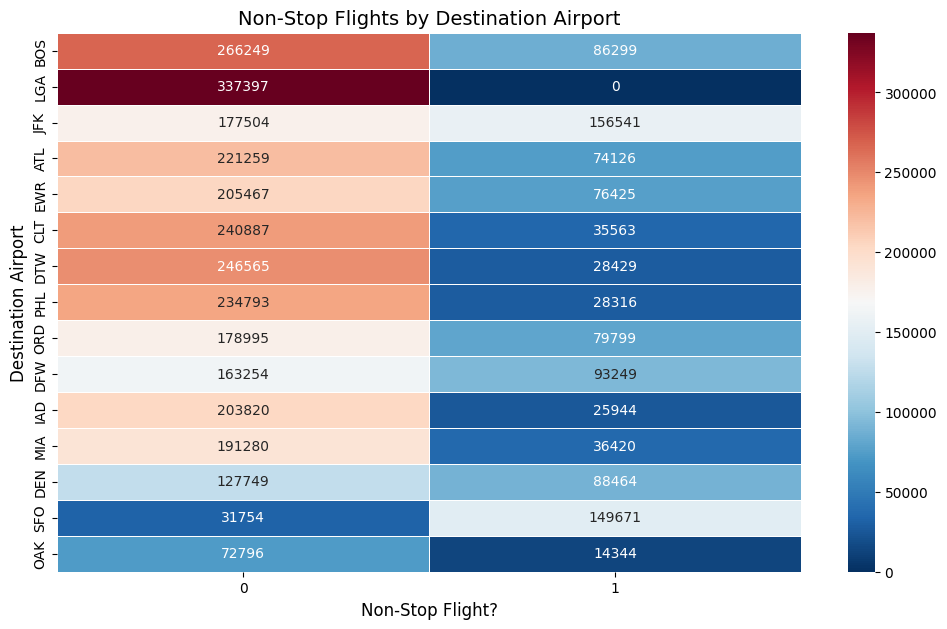

In [36]:
crosstab = pd.crosstab(df['destinationAirport'], df['isNonStop'])

#sort by total flights
crosstab['Total'] = crosstab.sum(axis=1)
crosstab = crosstab.sort_values(by='Total', ascending=False).drop(columns=['Total'])

# Plot heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(crosstab, annot=True, fmt="g", cmap="RdBu_r", linewidths=0.5, annot_kws={"size": 10})
plt.title("Non-Stop Flights by Destination Airport", fontsize=14)
plt.xlabel("Non-Stop Flight?", fontsize=12)
plt.ylabel("Destination Airport", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

The above visualization shows that some airports are much more common to be a "hub" for connecting flights like LGA and Boston. Some airports show evidence of more direct flights, like SFO which makes sense because of its close geographic proximity to LAX. 

In [37]:
#Understand interactions between categories. Good for feature engineering purposes
#Are certain Destinations more likely to be non-stop?
pd.crosstab(df['destinationAirport'], df['isNonStop'])


isNonStop,0,1
destinationAirport,,
ATL,221259,74126
BOS,266249,86299
CLT,240887,35563
DEN,127749,88464
DFW,163254,93249
DTW,246565,28429
EWR,205467,76425
IAD,203820,25944
JFK,177504,156541


## Categorical and Numerical Visual Comparisons

### Boxplots Comparing Total Fare to Categorical Variables 

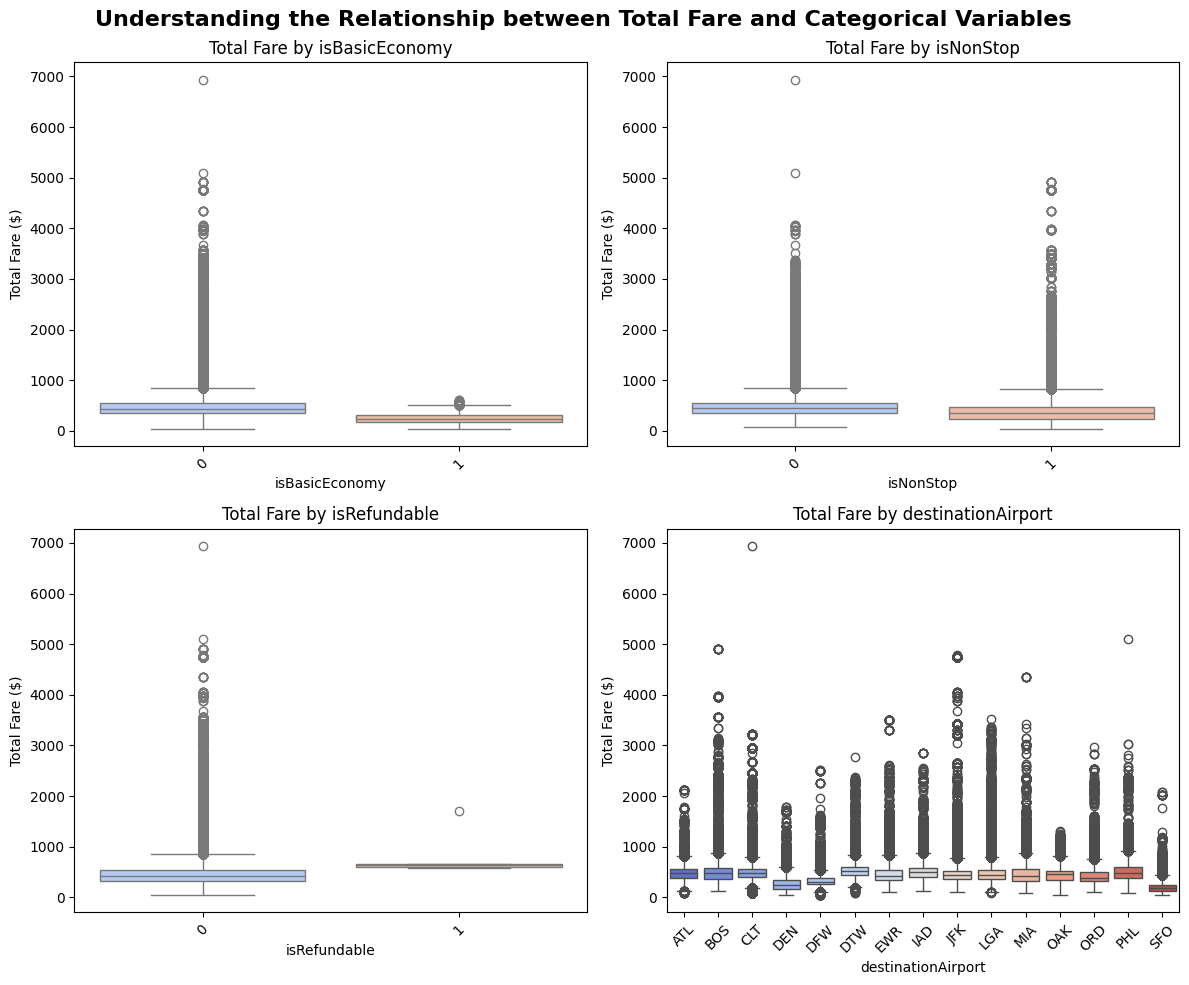

In [38]:
#How do categorical features affect price?
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
axes = axes.flatten()  


for i, col in enumerate(categorical_features_refined):  
    sns.boxplot(x=df[col], y=df['totalFare'], palette="coolwarm", hue=df[col], ax=axes[i], legend=False)
    axes[i].set_title(f"Total Fare by {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Total Fare ($)")
    axes[i].tick_params(axis='x', rotation=45)
fig.suptitle("Understanding the Relationship between Total Fare and Categorical Variables   ", fontsize=16, fontweight='bold')
plt.tight_layout() 
plt.show()


Basic economy fairs tend to be slightly cheaper. Non-stop vs connecting flights are surprisingly similar in fare, and have many outliers. This is similar to the total fares by destination airport, but we can see the geographically close airports to LAX (SFO and DEN) have slightly lower fares. These also have a lot of outliers, which we believe is more representative of the nature of airfare pricing models. 

### Boxplot Comparison of Flight Duration by Destination Airport

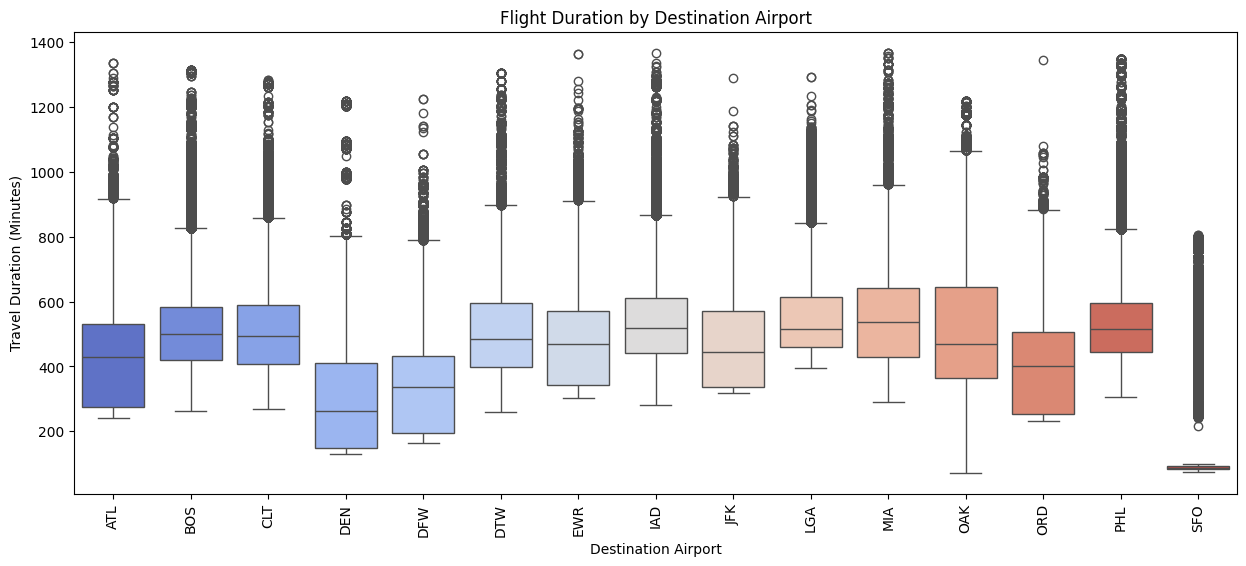

In [39]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df['destinationAirport'], y=df['travelDurationMinutes'], palette="coolwarm", hue=df['destinationAirport'], legend=False)
plt.xticks(rotation=90)
plt.title("Flight Duration by Destination Airport")
plt.xlabel("Destination Airport")
plt.ylabel("Travel Duration (Minutes)")
plt.show()


## Time-Related Feature Engineering 

### Creation of Time Related Features (Flight and Search Month/Day), Price Per Mile, Days to Departure

In [40]:
#Time Related Features
df['daysToDeparture'] = (df['flightDate'] - df['searchDate']).dt.days

df['flightMonth'] = df['flightDate'].dt.month
df['flightDay'] = df['flightDate'].dt.dayofweek

df['searchMonth'] = df['searchDate'].dt.month
df['searchDay'] = df['searchDate'].dt.dayofweek

#Calculate the price per mile 
df['pricePerMile'] = df['totalFare'] / df['totalTravelDistance']

## EDA Visualizations of Engineered Features

### Distribution of Days to Departure

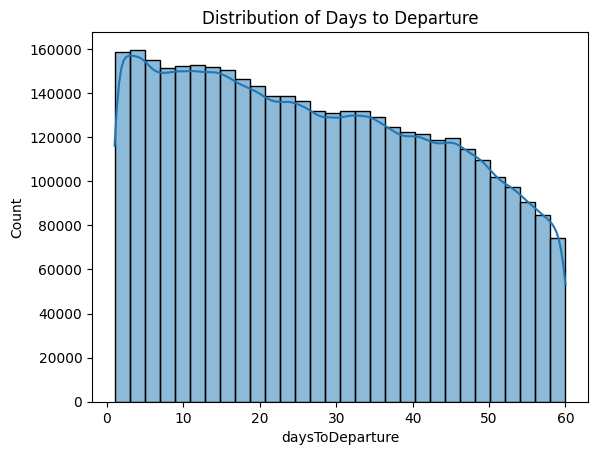

In [41]:
# Distribution of days to departure
sns.histplot(df['daysToDeparture'], bins=30, kde=True)
plt.title("Distribution of Days to Departure")
plt.show()

Most of the searches are made closer to departure, with a slight decline farther out from departure. However, this is likely because we selected only June-August, which means we have ultimately eliminated the searches for flights that happen 60 days out from june (in April/May)

### Comparison of Days to Departure and Average Fare

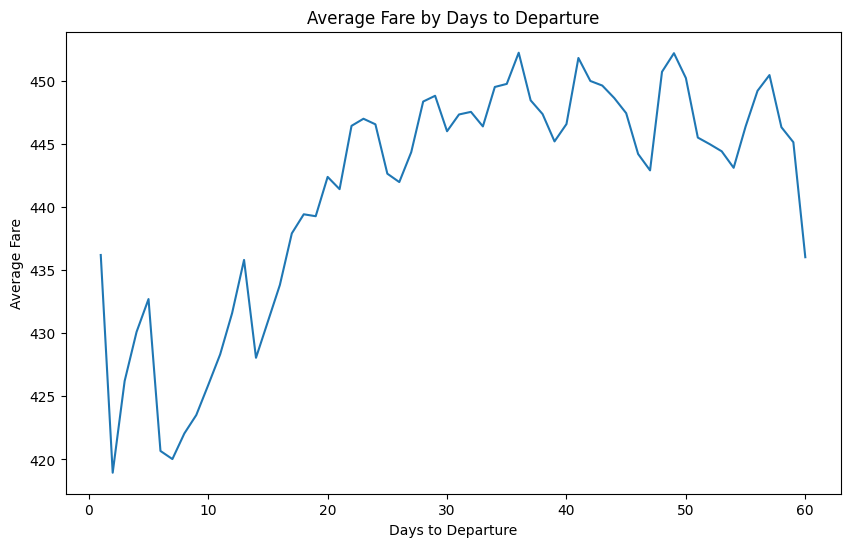

In [42]:
# Group by days to departure to analyze average fare trends
avg_fare_trend = df.groupby('daysToDeparture')['totalFare'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_fare_trend, x='daysToDeparture', y='totalFare')
plt.title("Average Fare by Days to Departure")
plt.xlabel("Days to Departure")
plt.ylabel("Average Fare")
plt.show()

Surprisingly, fares tend to be more expensive when booked between the 20-60 day mark. Between 0-20 days there are huge amounts of fluctuation in pricing, including drastic drops and drastic price hikes. This likely is a balance between airlines attempting to fill empty seats, but surging prices for individuals that need last minute flights. 

### Comparison of Non-Stop Flights to Day of the Week 

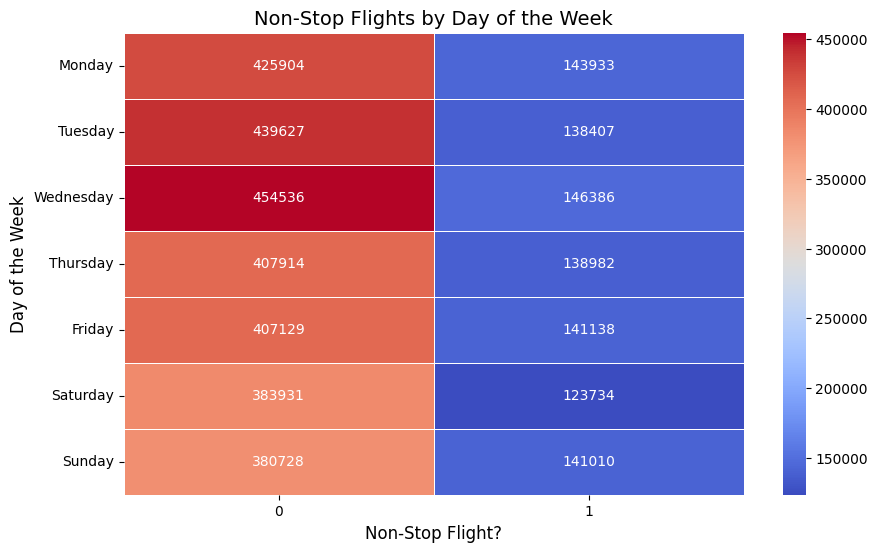

In [43]:
#Compare non-stop flights by day of the week
df['flightDayOfWeek'] = pd.to_datetime(df['flightDate']).dt.day_name()

# Define the correct order for days of the week
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df['flightDayOfWeek'] = pd.Categorical(df['flightDayOfWeek'], categories=day_order, ordered=True)

crosstab = pd.crosstab(df['flightDayOfWeek'], df['isNonStop']).loc[day_order]


plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt="g", cmap="coolwarm", linewidths=0.5)
plt.title("Non-Stop Flights by Day of the Week", fontsize=14)
plt.xlabel("Non-Stop Flight?", fontsize=12)
plt.ylabel("Day of the Week", fontsize=12)
plt.show()



While most of the non-stop flights were relatively evenly distributed across the days of the week, we see slightly more direct flights on saturday, and slightly less on wednesday. 

## Holiday Related Feature Engineering

Below we use the holidays API to create two features. The first is a categorical variable that defines if the flight occurs on the holiday. The next is a feature that shows the number of days until a holiday. 

In [44]:
us_holidays = holidays.US()
df['isHoliday'] = df['flightDate'].apply(lambda date: 1 if date in us_holidays else 0)

# Create pre-holiday and post-holiday indicators
df['preHolidayFlight'] = df['flightDate'].apply(lambda date: 1 if any((date - pd.Timedelta(days=i)) in us_holidays for i in range(1, 6)) else 0)
df['postHolidayFlight'] = df['flightDate'].apply(lambda date: 1 if any((date + pd.Timedelta(days=i)) in us_holidays for i in range(1, 6)) else 0)

# Compute daysUntilHoliday
def get_daysUntilHolidayiday(date):
    holidays_list = sorted([pd.Timestamp(holiday) for holiday in us_holidays.keys()])
    
    # Find the nearest holiday before and after the flight date
    previous_holiday = max([h for h in holidays_list if h <= date], default=None)
    next_holiday = min([h for h in holidays_list if h >= date], default=None)
    
    # Calculate the days until the nearest holiday
    daysBeforeHoliday = (date - previous_holiday).days if previous_holiday else float('inf')
    daysAfterHoliday = (next_holiday - date).days if next_holiday else float('inf')

    # Return the smallest absolute difference (positive for future, negative for past holidays)
    if abs(daysBeforeHoliday) < abs(daysAfterHoliday):
        return -daysBeforeHoliday  # Negative if the closest holiday was in the past
    return daysAfterHoliday  # Positive if the closest holiday is in the future

# Apply the function to compute daysUntilHoliday
df['daysUntilHoliday'] = df['flightDate'].apply(get_daysUntilHolidayiday)

## Segment Feature Engineering 


### Number of Legs

In [ ]:
# Find the number of flight legs 
df['numberLegs'] = df['segmentsDepartureTimeEpochSeconds'].str.count(r'\|\|') + 1
max_segments = df['numberLegs'].max()

print(f"Maximum number of segments in any row: {max_segments}")



Maximum number of segments in any row: 4


### Breakdown of Departure and Arrival Time Features

In [49]:
# Split departure and arrivals into separate columns
df[['dep_1', 'dep_2', 'dep_3', 'dep_4']] = df['segmentsDepartureTimeEpochSeconds'].str.split(r'\|\|', expand=True)
df[['arr_1', 'arr_2', 'arr_3', 'arr_4']] = df['segmentsArrivalTimeEpochSeconds'].str.split(r'\|\|', expand=True)

# Convert epoch times to datetime
for col in ['dep_1', 'dep_2', 'dep_3', 'dep_4', 'arr_1', 'arr_2', 'arr_3', 'arr_4']:
    df[col] = pd.to_datetime(df[col].astype(float), unit='s', errors='coerce')
    

In [50]:
#Find hour of departure and arrival. Inspired by literature
df["departureHour"] = df["dep_1"].dt.hour
df["departureMinute"] = df["dep_1"].dt.minute

# Get the last valid arrival time by backfilling from right to left
df["final_arrival"] = df[["arr_4", "arr_3", "arr_2", "arr_1"]].bfill(axis=1).iloc[:, 0]

# Extract hour and minute from the final arrival time
df["arrivalHour"] = df["final_arrival"].dt.hour
df["arrivalMinute"] = df["final_arrival"].dt.minute

# Create a column to check if final arrival is on the next day and convert to 0/1
df["arrivalNextDay"] = (df["final_arrival"].dt.date > df["dep_1"].dt.date).astype(int)


# Drop the intermediate column if not needed
df.drop(columns=["final_arrival"], inplace=True)



### Calculate Length of Layover

In [51]:
# Calculate layover times for each segment
def calculate_layover(dep_col, arr_col, next_dep_col):
    if pd.notna(dep_col) and pd.notna(arr_col):
        return (next_dep_col - arr_col).total_seconds() / 3600 if pd.notna(next_dep_col) else 0
    return 0

# Calculate layover times for each segment
df['layover_1'] = df.apply(lambda row: calculate_layover(row['dep_1'], row['arr_1'], row['dep_2']), axis=1)
df['layover_2'] = df.apply(lambda row: calculate_layover(row['dep_2'], row['arr_2'], row['dep_3']), axis=1)
df['layover_3'] = df.apply(lambda row: calculate_layover(row['dep_3'], row['arr_3'], row['dep_4']), axis=1)

# Sum layover times, handling NaNs
df['totalLayoverTime'] = df[['layover_1', 'layover_2', 'layover_3']].sum(axis=1, skipna=True)




### Find the Total Flight Duration NOT Including Layovers (Unlike Original Flight Duration Feature)

In [52]:
# Calculate the total flight duration, excluding layovers
def calculate_flight_duration(row):
    total_duration = 0
    num_segments = row['numberLegs']
    
    # Ensure there are valid departure and arrival times to compute the duration
    if num_segments >= 1 and pd.notna(row['dep_1']) and pd.notna(row[f'arr_{num_segments}']):
        # Total time between first departure and last arrival
        total_duration = (row[f'arr_{num_segments}'] - row['dep_1']).total_seconds() / 3600
    
    # Subtract layover times to get only time spent flying
    total_duration -= row['totalLayoverTime']
    
    return total_duration

# Apply the function to calculate total flight duration
df['totalAirtime'] = df.apply(calculate_flight_duration, axis=1)

### Find Airport Where First Layover Occurs

In [53]:
# Extract the first layover airport code (if it exists)
# Assuming the 'segmentsArrivalAirportCode' column contains the layover airport codes, separated by '||'
df['segmentsArrivalAirportCode'] = df['segmentsArrivalAirportCode'].fillna('')
df['firstLayoverAirport'] = df['segmentsArrivalAirportCode'].apply(
    lambda x: x.split('||')[0] if isinstance(x, str) and '||' in x else x
)
print(df['firstLayoverAirport'].value_counts())


firstLayoverAirport
DFW    393429
DEN    332506
ORD    306334
SFO    301204
ATL    271101
        ...  
EUG         6
MFR         5
BWI         3
COS         2
OMA         1
Name: count, Length: 67, dtype: int64


### Find Airline that Primarily Serviced Trip

In [54]:
#Find the primary airline over all the segments of a flight 
df['mainAirline'] = df['segmentsAirlineName'].str.split(r'\|\|').apply(lambda x: max(set(x), key=x.count) if isinstance(x, list) else x)


### Separate Cabin Class for Each Stage of Trip

In [55]:
# Use raw string to avoid escape sequence warning
df['cabin_classes'] = df['segmentsCabinCode'].str.split(r'\|\|')

# Remove any unnecessary characters (like leading/trailing spaces or empty strings)
df['cabin_classes'] = df['cabin_classes'].apply(lambda x: [i.strip() for i in x if i.strip() != ''])

# Verify the first few rows to ensure proper splitting
print(df['cabin_classes'].head())

# Check if all cabin classes are the same for each flight
df['same_cabin_type'] = df['cabin_classes'].apply(lambda x: len(set(x)) == 1)

# Count flights with same vs. different cabin types
same_cabin_count = df['same_cabin_type'].sum()
different_cabin_count = len(df) - same_cabin_count

print(f"Number of flights with the same cabin type: {same_cabin_count}")
print(f"Number of flights with different cabin types: {different_cabin_count}")

# Split based on '||' and find unique cabin classes
df['cabin_classes'] = df['segmentsCabinCode'].str.split(r'\|\|')

# Flatten the list and get the unique cabin classes
unique_cabin_classes = df['cabin_classes'].explode().unique()

# Display the unique cabin classes
print("Unique cabin classes:", unique_cabin_classes)

0    [coach, coach]
1    [coach, coach]
2    [coach, coach]
3    [coach, coach]
4    [coach, coach]
Name: cabin_classes, dtype: object
Number of flights with the same cabin type: 3865627
Number of flights with different cabin types: 7732
Unique cabin classes: ['coach' 'premium coach' 'first' 'business']


### Create Ordering of Cabin Classes (Lowest Coach, Highest First)

In [56]:
# Split SegmentsCabinCode into individual cabin classes
df['cabin_classes'] = df['segmentsCabinCode'].str.split(r'\|\|')

# Convert cabin classes into unique combinations of classes
df['cabinClassesCombination'] = df['cabin_classes'].map(lambda x: '|'.join(sorted(set(x))) if isinstance(x, list) else '')

# Define the ordered combinations
raw_combinations = [
    'coach', 'coach|premium coach', 'premium coach', 'coach|business',
    'premium coach|business', 'business', 'coach|first', 'premium coach|first',
    'first|business', 'first'
]

# **Ensure all predefined combinations are also sorted**
ordered_combinations = ['|'.join(sorted(comb.split('|'))) for comb in raw_combinations]

# Make a fast lookup dictionary for mapping
combination_mapping = {comb: idx for idx, comb in enumerate(ordered_combinations)}

# Map the sorted combinations 
df['cabin_classes_ordinal'] = df['cabinClassesCombination'].map(combination_mapping)

# Check for missing mappings
missing_combinations = df.loc[df['cabin_classes_ordinal'].isna(), 'cabinClassesCombination'].unique()
print("Missing cabin class combinations:", missing_combinations)

Missing cabin class combinations: []


## Segment Feature Engineering Visualizations

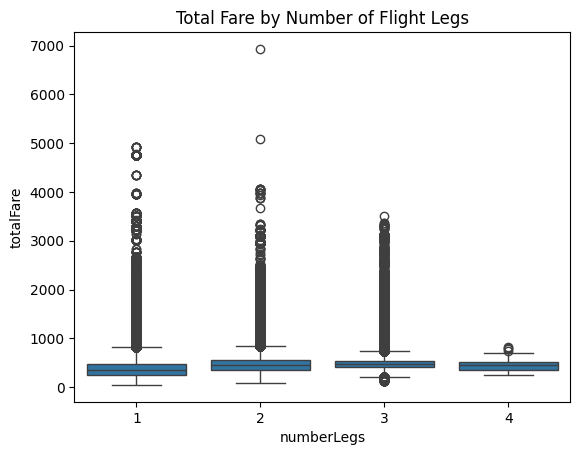

In [68]:
# Relationship between number of segments and totalFare
sns.boxplot(x='numberLegs', y='totalFare', data=df)
plt.title("Total Fare by Number of Flight Legs")
plt.show()

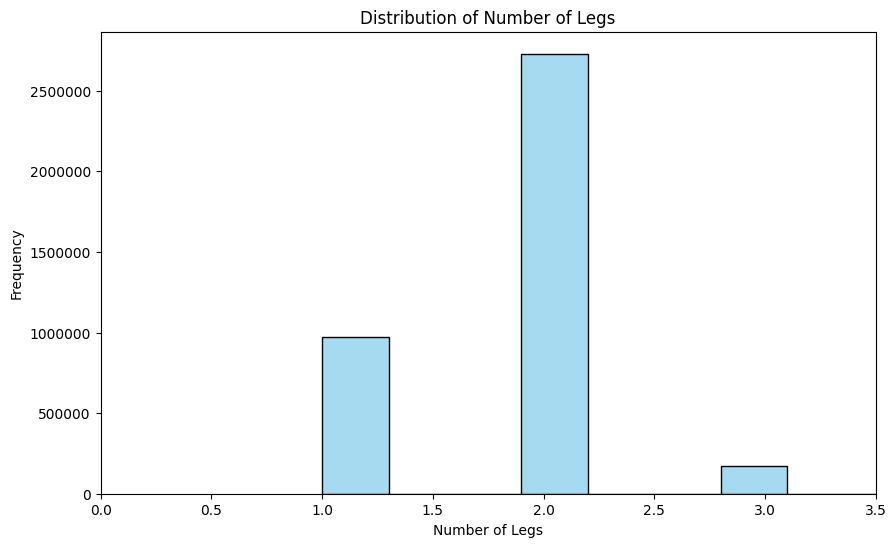

In [69]:
#Visualizing the distribution of legs of flights
plt.figure(figsize=(10,6))
sns.histplot(df['numberLegs'], bins=10, kde=False, color='skyblue')
plt.title("Distribution of Number of Legs")
plt.xlabel("Number of Legs")
plt.ylabel("Frequency")
plt.xlim(0, 3.5)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

## Lag Feature Engineering
Lag features represent the values of a variable at previous time points


There are a high occurrence of legIds that only appear once, meaning the use of legId for grouping of lag features is not ideal, it can lead to excessive granularity and not be as useful of a feature. Instead, we can group by starting and destination airports. 

In [57]:
# Count occurrences of each legId
legid_counts = df['legId'].value_counts()
print(legid_counts.head(10))

#Statistics about legId occurrences
print("Unique legIds:", legid_counts.count())
print("Max occurrences of a legId:", legid_counts.max())
print("Min occurrences of a legId:", legid_counts.min())
print("Average occurrences per legId:", legid_counts.mean())

# Check how many legIds occur only once
single_occurrences = (legid_counts == 1).sum()
sixty_occurrences = (legid_counts == 60).sum()
print("Number of legIds that appear only once:", single_occurrences)
print("Number of legIds that appear 60 times:", sixty_occurrences)

legId
1eb0e588bd01f1c3186ac18d25170f9a    60
46e498200858215044c2785a6ed65b0d    60
cea59416664b64aa0f2360782afe9704    60
e11157f8f107f9b7a6cb169a18b7edd3    60
52fdb28b76a8142e78171ec3beb5a68a    60
4ff68b29bd7078702fcb1e1151f67e8e    60
5a6a8040a10d321dda63bd4908d04769    60
4cbcddb206b6ca0655c10defd6f0c91f    60
f93cecbc9b551a3b94cc34c0c7fcc51c    60
ca006e2d85e776e2d51af3ad009e7a83    60
Name: count, dtype: int64
Unique legIds: 275531
Max occurrences of a legId: 60
Min occurrences of a legId: 1
Average occurrences per legId: 14.05779748921174
Number of legIds that appear only once: 52951
Number of legIds that appear 60 times: 886


In [58]:
# Sort by route and search date
df = df.sort_values(by=['destinationAirport', 'searchDate'])

# Create lag features for 1-day, 7-day, and 30-day periods
df['fareLag_1'] = df.groupby(['destinationAirport'])['totalFare'].shift(1)
df['fareLag_7'] = df.groupby(['destinationAirport'])['totalFare'].shift(7)
df['fareLag_30'] = df.groupby(['destinationAirport'])['totalFare'].shift(30)

# Create rolling average features
df['fare_rolling_avg_7'] = df.groupby(['destinationAirport'])['totalFare'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['fare_rolling_avg_30'] = df.groupby(['destinationAirport'])['totalFare'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Fill missing values in lag features using rolling averages
df['fareLag_1'] = df['fareLag_1'].fillna(df['fare_rolling_avg_30'])  # Prefer 30-day average
df['fareLag_1'] = df['fareLag_1'].fillna(df['fare_rolling_avg_7'])   # If still NaN, use 7-day avg
df['fareLag_1'] = df['fareLag_1'].fillna(method='ffill')             # Finally, use forward fill

# Inspect the results
print(df[['destinationAirport', 'searchDate', 'totalFare', 'fareLag_1', 'fare_rolling_avg_7', 'fare_rolling_avg_30']].head(20))


   destinationAirport searchDate  totalFare  fareLag_1  fare_rolling_avg_7  \
0                 ATL 2022-04-17     193.99     193.99          193.990000   
1                 ATL 2022-04-17     248.61     193.99          221.300000   
2                 ATL 2022-04-17     277.60     248.61          240.066667   
3                 ATL 2022-04-17     277.60     277.60          249.450000   
4                 ATL 2022-04-17     277.60     277.60          255.080000   
5                 ATL 2022-04-17     277.60     277.60          258.833333   
6                 ATL 2022-04-17     323.60     277.60          268.085714   
7                 ATL 2022-04-17     323.60     323.60          286.601429   
8                 ATL 2022-04-17     323.60     323.60          297.314286   
9                 ATL 2022-04-17     323.60     323.60          303.885714   
10                ATL 2022-04-17     323.60     323.60          310.457143   
11                ATL 2022-04-17     327.60     323.60          

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_96650/1650217623.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['fareLag_1'] = df['fareLag_1'].fillna(method='ffill')             # Finally, use forward fill


## Visualization of Correlation Between Fare and Lag Features 

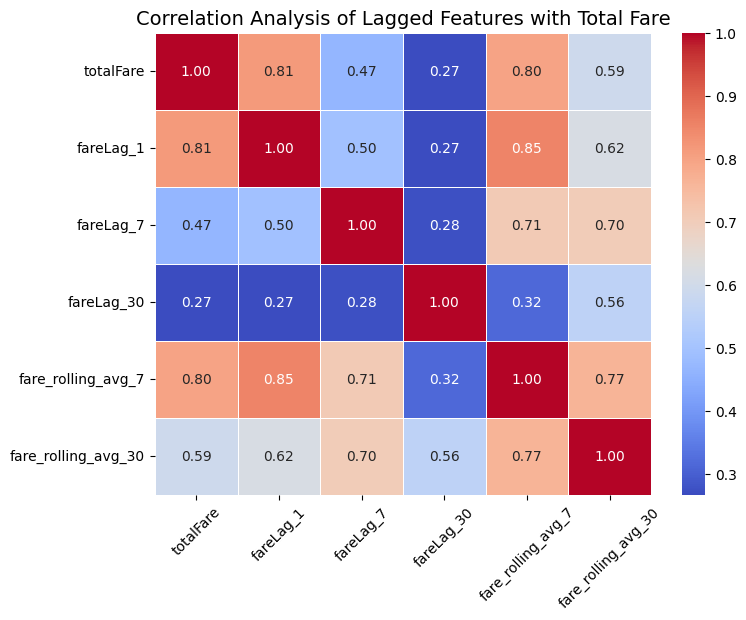

In [59]:
#Check correlation between lag features and totalFare

lag_features = ['totalFare', 'fareLag_1', 'fareLag_7', 'fareLag_30', 'fare_rolling_avg_7', 'fare_rolling_avg_30']
correlation_matrix = df[lag_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Analysis of Lagged Features with Total Fare", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()



The most correlated features are fare_lag_1, fare_rolling_avg_7, and fare_rolling_avg_30. However, fare_lag_1 and fare_rolling_avg_7 have high correlation with each other, which may introduce redundancy into the model. One may need to be dropped if multicollinearity affects model 

### Drop Repetitive Lag Features

In [60]:
#Drop the lag features that do not have a high correlation with totalFare
df = df.drop(['fare_rolling_avg_7', 'fareLag_7', 'fareLag_30'], axis=1)

#All elements of searchDate have been extracted, drop searchDate
df = df.drop(columns=['searchDate'], axis=1)

## Removing Redundant or Unnecessary Columns for Ease of Future Use

In [61]:
#Drop Segment columns that have already been split or were ultimately unneeded   
#Drop column startingAirport. LAX is the only starting airport 
#Drop legId, offers no useful prediction tools and isn't needed for any other use
#Drop baseFare, only need one between baseFare and totalFare (totalFare more comprehensive)
#We are interested in the departing and arriving airport code only, so the intermediate airport code can be dropped 
#Drop Departure and Arrival columns now that all necessary information has been extracted
df = df.drop(['startingAirport', 'legId', 'baseFare', 'segmentsDurationInSeconds', 
                      'segmentsDistance', 'segmentsDepartureTimeEpochSeconds', 
                      'segmentsArrivalTimeEpochSeconds', 'flightDate',
                      'dep_1', 'dep_2', 'dep_3', 'dep_4', 
                      'arr_1', 'arr_2', 'arr_3', 'arr_4', 
                      'layover_1', 'layover_2', 'layover_3',  
                      'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 
                      'segmentsAirlineName', 'segmentsCabinCode', 'same_cabin_type'], axis=1).reset_index(drop=True)

## Checking Datat Types and for Any Missing Values 

In [62]:
#Review remaining columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3873359 entries, 0 to 3873358
Data columns (total 35 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   destinationAirport       object  
 1   fareBasisCode            object  
 2   isBasicEconomy           int64   
 3   isRefundable             int64   
 4   isNonStop                int64   
 5   totalFare                float64 
 6   seatsRemaining           int64   
 7   totalTravelDistance      float64 
 8   travelDurationMinutes    int64   
 9   daysToDeparture          int64   
 10  flightMonth              int32   
 11  flightDay                int32   
 12  searchMonth              int32   
 13  searchDay                int32   
 14  pricePerMile             float64 
 15  flightDayOfWeek          category
 16  isHoliday                int64   
 17  preHolidayFlight         int64   
 18  postHolidayFlight        int64   
 19  daysUntilHoliday         int64   
 20  numberLegs              

In [63]:
#Check for any missing or null values after feature engineering 
missing_values = df.isnull().sum()
print(missing_values)

destinationAirport         0
fareBasisCode              0
isBasicEconomy             0
isRefundable               0
isNonStop                  0
totalFare                  0
seatsRemaining             0
totalTravelDistance        0
travelDurationMinutes      0
daysToDeparture            0
flightMonth                0
flightDay                  0
searchMonth                0
searchDay                  0
pricePerMile               0
flightDayOfWeek            0
isHoliday                  0
preHolidayFlight           0
postHolidayFlight          0
daysUntilHoliday           0
numberLegs                 0
departureHour              0
departureMinute            0
arrivalHour                0
arrivalMinute              0
arrivalNextDay             0
totalLayoverTime           0
totalAirtime               0
firstLayoverAirport        0
mainAirline                0
cabin_classes              0
cabinClassesCombination    0
cabin_classes_ordinal      0
fareLag_1                  0
fare_rolling_a

## Outputting the Cleaned and Processed Dataset 

In [64]:
#Output the cleaned and processed dataset
output_path = "cleaned_data_snappy.parquet"
df.to_parquet(output_path, engine='pyarrow', compression='snappy', index=False)

print(f"Snappy-compressed Parquet file saved to {output_path}")

# Save as CSV
df.to_csv('cleaned_processed_data.csv', index=False)


Snappy-compressed Parquet file saved to cleaned_data_snappy.parquet


## Handling Outliers and Capping

Outliers must be thoughtfully handled in this case because we feel that outliers can often represent the extreme values of airfare that occur due to surge pricing and other features. However, models may perform better if outliers are properly assessed (especially linear regression and LSTM models. )

### Visualization of the Distribution of Numerical Features 

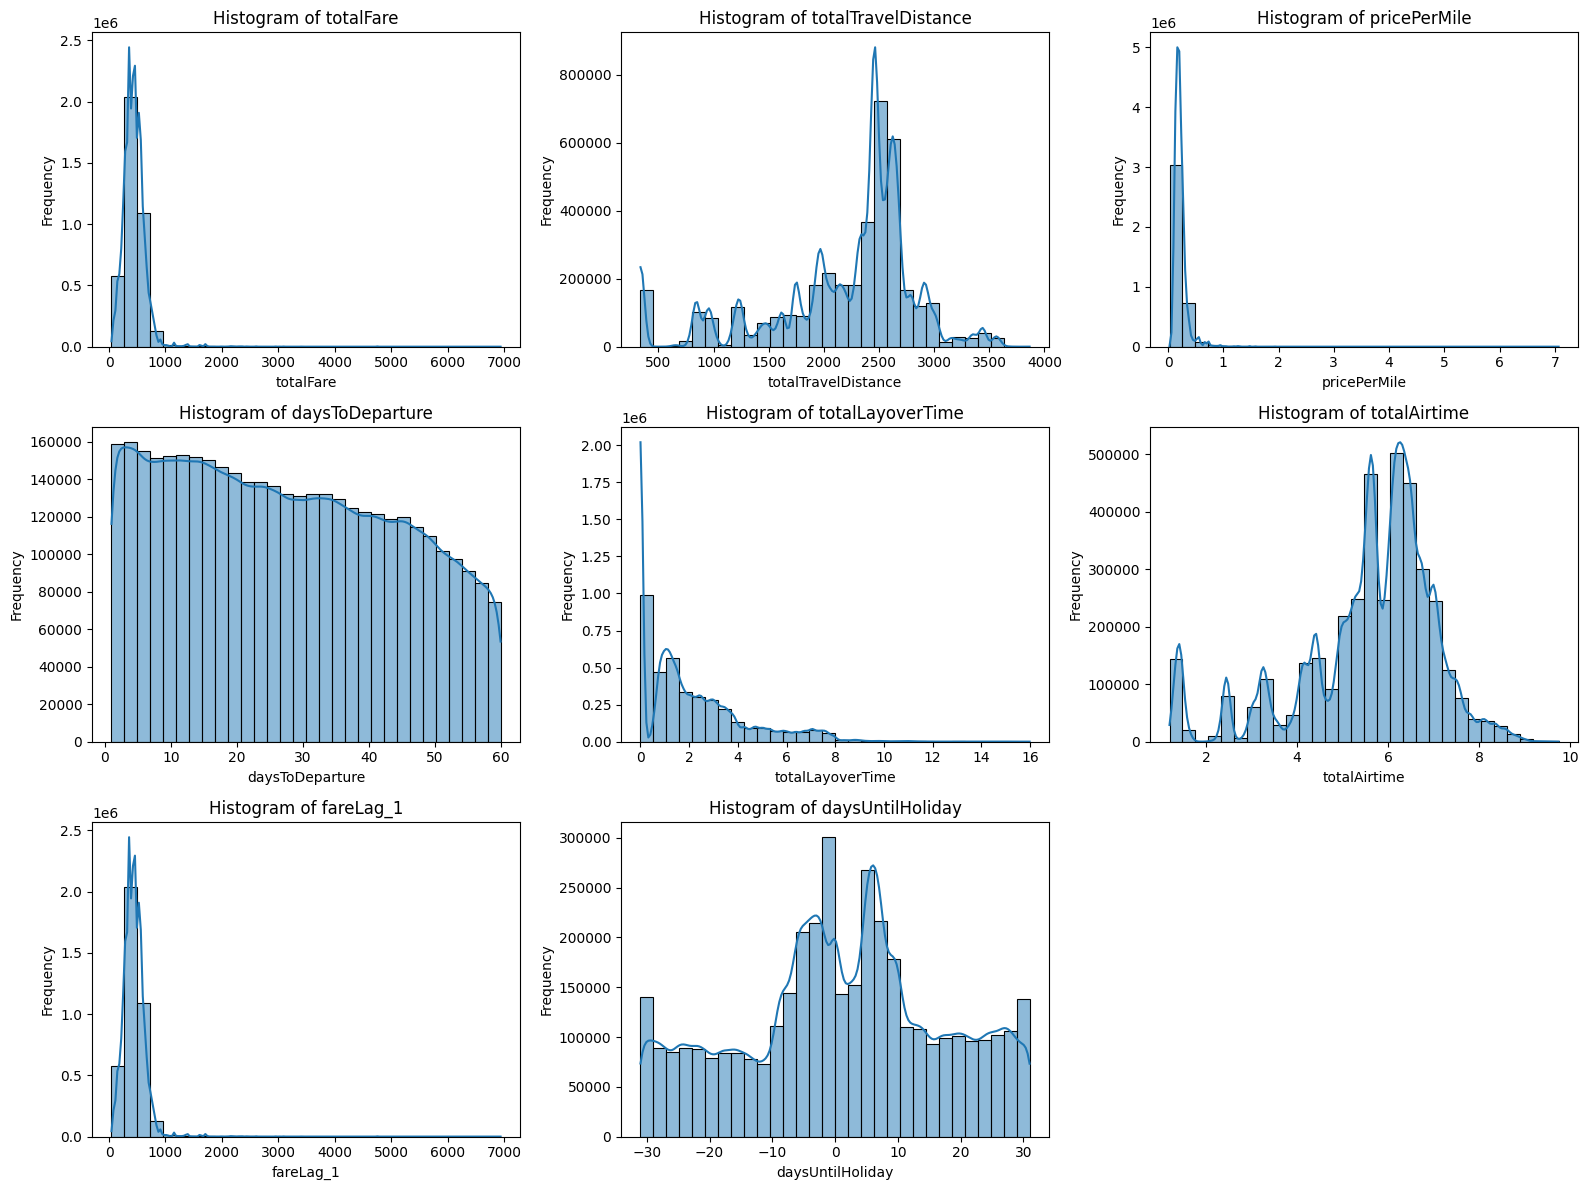

In [65]:
# List of continuous numerical features to check for outliers
outlier_columns = [
    'totalFare', 
    'totalTravelDistance', 
    'pricePerMile', 
    'daysToDeparture', 
    'totalLayoverTime', 
    'totalAirtime', 
    'fareLag_1', 
    'daysUntilHoliday'
]

# Plot histograms for each feature
plt.figure(figsize=(16, 12))
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


These distributions show that most of the numerical features do not have a normal distribution. Capping may help improve distributions. 

### The Effects of IQR Capping on Distribution

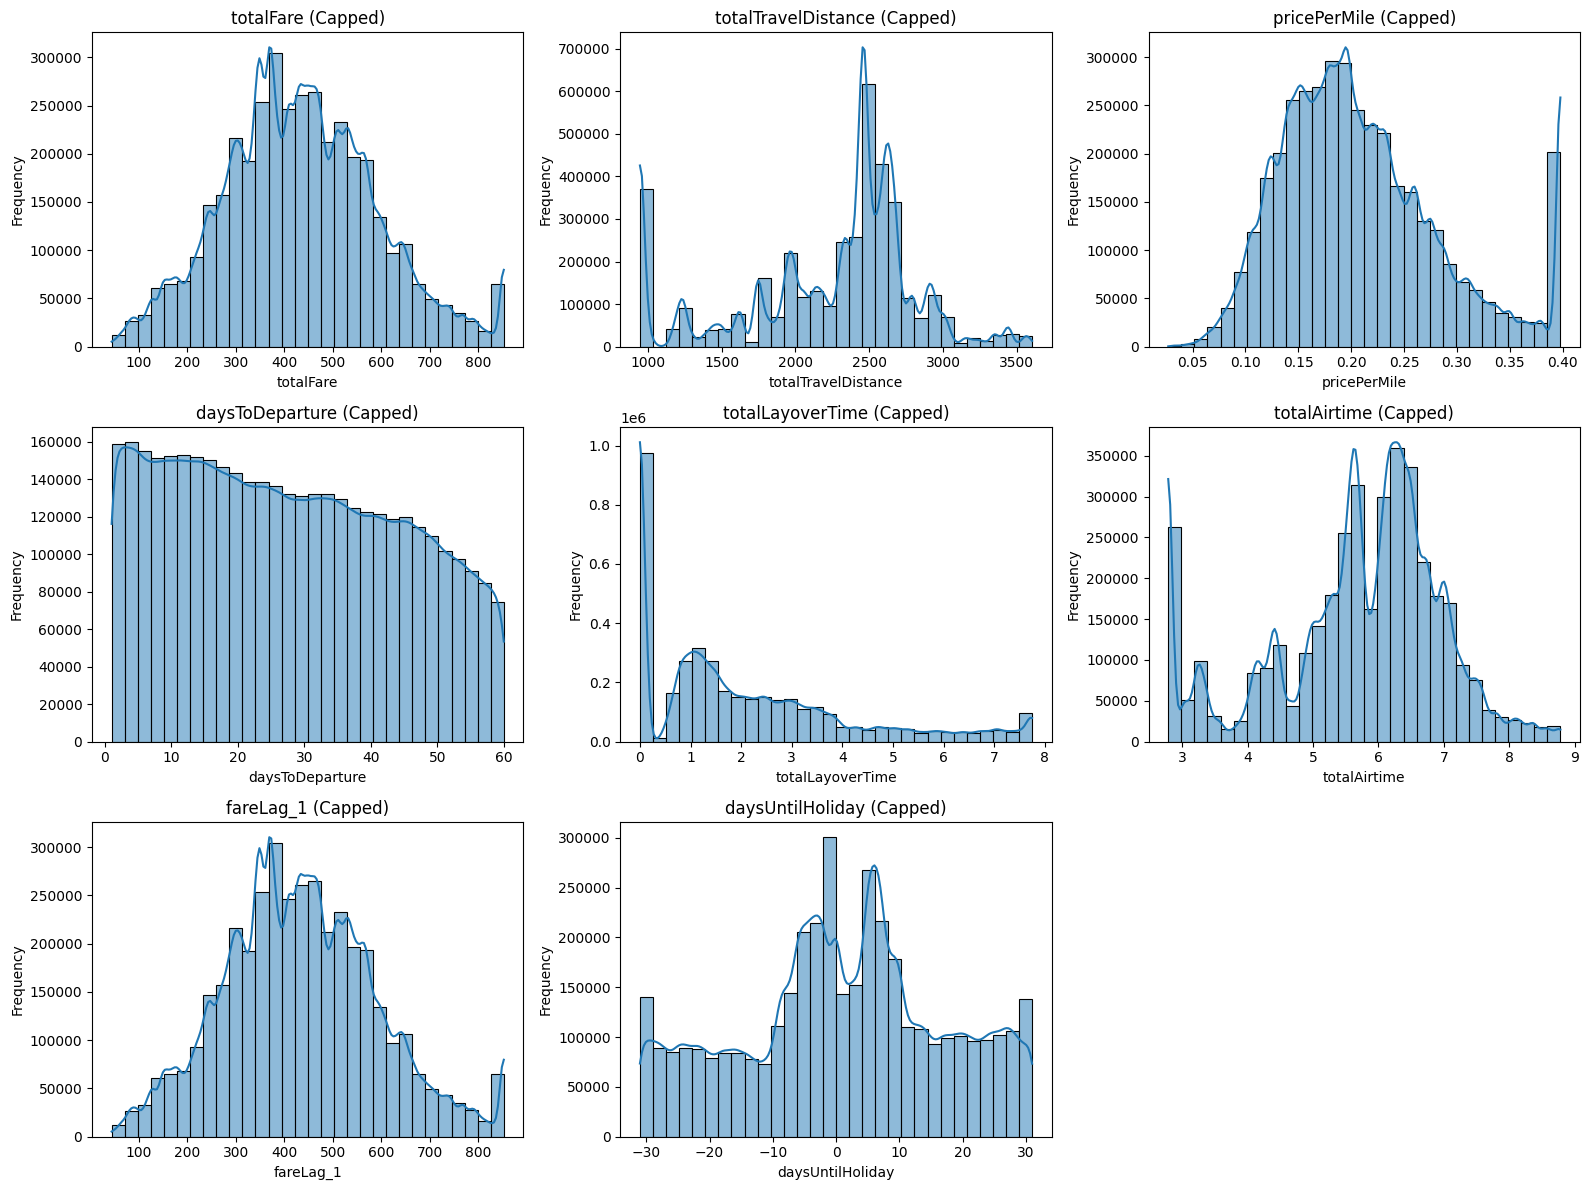

Dataset size after capping: 3873359


In [66]:
# Choose a multiplier for the IQR; adjust if needed (e.g., 1.5 or 2.0)
multiplier = 1.5

# Create a copy of the original dataframe for capping outliers
df_capped = df.copy()

# Apply capping on each column using the IQR method
for col in outlier_columns:
    Q1 = df_capped[col].quantile(0.25)
    Q3 = df_capped[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    # Cap the values at the calculated bounds
    df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)

# Visualize the distributions after capping to review the effect
plt.figure(figsize=(16, 12))
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_capped[col].dropna(), kde=True, bins=30)
    plt.title(f'{col} (Capped)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Print a summary to check that the dataset size remains unchanged
print("Dataset size after capping:", df_capped.shape[0])


After applying capping based on IQR, we can see that the distributions of the features are more "normal" which MAY lead to better model performance. This should be furthered explored. 

## Checking Correlation for Feature Selection Purposes

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_96650/1604261814.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values_updated, y=features_updated, orient='h', palette='Blues_r')


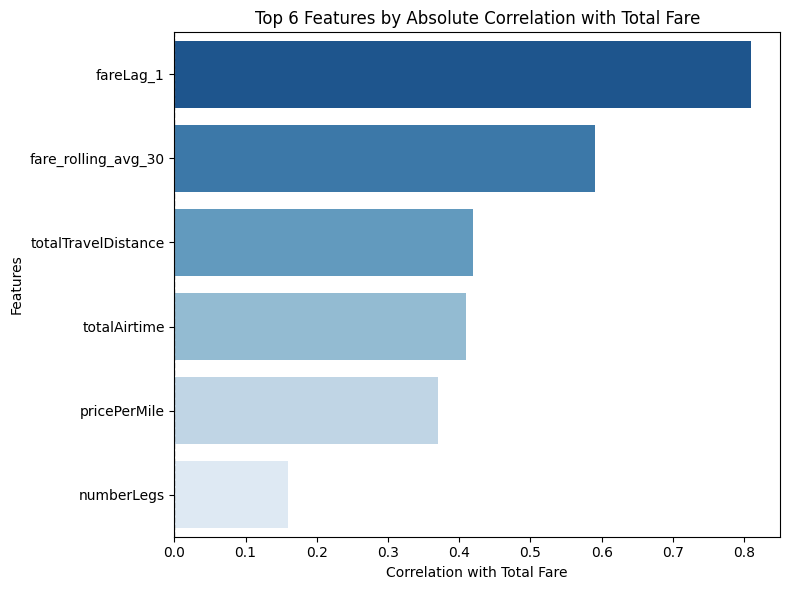

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Updated feature correlations (removing cabin class ordinal, flight day, and post-holiday flight)
correlations_updated = {
    "fareLag_1": 0.81,
    "fare_rolling_avg_30": 0.59,
    "totalTravelDistance": 0.42,
    "totalAirtime": 0.41,
    "pricePerMile": 0.37,
    "numberLegs": 0.16,
}

# Sort by absolute correlation in descending order
sorted_corr_updated = dict(sorted(correlations_updated.items(), key=lambda x: abs(x[1]), reverse=True))

# Keep only the top 10
top_10_updated = dict(list(sorted_corr_updated.items())[:10])

# Prepare data for plotting
features_updated = list(top_10_updated.keys())
values_updated = list(top_10_updated.values())

plt.figure(figsize=(8, 6))
sns.barplot(x=values_updated, y=features_updated, orient='h', palette='Blues_r')
plt.title("Top 6 Features by Absolute Correlation with Total Fare")
plt.xlabel("Correlation with Total Fare")
plt.ylabel("Features")
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()

# Save the figure locally
plt.savefig("updated_top_10_features_bar_chart.png")
plt.show()
